# Tutorial Notebooks
This is the second in a series of how-to notebooks that walk through producing simulated slitless spectroscopy images using Grizli. This notebook goes through producing a segmentaion image. Strictly speaking, we only need the code from section 5 to run a simulation. The rest of the notebook is an exploration of how segmentation images are produced and some useful information for troubleshooting.

## Outline
1) What is a Segmentation Image?
2) Image Prep Steps
3) Simple Segmentation
4) Deblending
5) Simplified, all-in-one command
6) Building a catalog

#### 1) What is a Segmentation Image

The goal of creating a segmentation image from a direct image is to create a map of discrete objects in that direct image. It works by setting the value of connected pixels equal to the id of that object. A simple example is shown below with a 5x5 array with two objects in it:

    [ 3  2  1  0  0 ]            [ 1  1  1  0  0 ]
    [ 2  1  0  0  0 ]            [ 1  1  0  0  0 ]
    [ 1  0  0  0  0 ]     -->    [ 1  0  0  0  0 ]
    [ 0  0  0  1  2 ]            [ 0  0  0  2  2 ]
    [ 0  0  0  2  3 ]            [ 0  0  0  2  2 ]

Note: The tools we use generally assume 8-connectivity by default. So, diagonal pixels are said to be connected by default.

    4-connected         8-connected
    [0 1 0]             [1 1 1]
    [1 1 1]             [1 1 1]
    [0 1 0]             [1 1 1]


#### 2) Image Prep Steps
When creating a segmentation image, it is important to start with an image that is background subtracted and convolved. The background subtraction ensures your segmentation image is identifying objects, not background abnormalities. The convolution smoothes objects so that no object is not arbitrarily split in two by bad pixels or dark regions.

In [1]:
# Tools for plotting and showing progress
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.0, 4.94)

# Let's work in the tutorial/fits_files folder to make our files easy to access
import os
os.chdir('/Users/keith/astr/research_astr/summer-roman-project/tutorial/fits_files') # Hardcoded path
# os.chdir(os.path.join(os.getcwd(), 'fits_files')) # Relative path

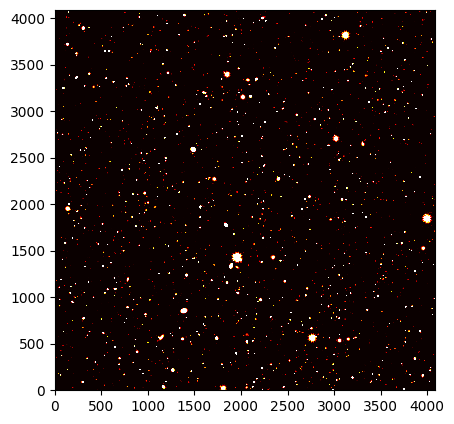

In [2]:
# Import fits tools
from astropy.io import fits

# Open fits file
direct_fits = fits.open("GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits")
data, hdr = direct_fits[1].data, direct_fits[1].header

# Show
plt.imshow(data, vmin=0.4, vmax=1., cmap='hot', origin='lower')

Background min: 0.24822695553302765
Background max: 0.24822695553302765
Background mean: 0.24822695553302765


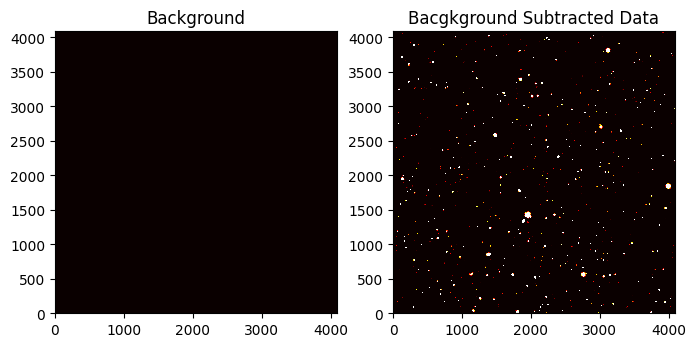

In [3]:
# Import background subtraction tools
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()

# box_size should be a scalar of the full image size and filter_size should be a scalar of box_size
bkg = Background2D(data, box_size=(511,511), filter_size=(7,7), bkg_estimator=bkg_estimator)
# Subtract off the background
data -= bkg.background

# Show background and background subtracted image side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(bkg.background, origin='lower', cmap='hot')
ax1.set_title("Background")
ax2.imshow(data, vmin=0.4, vmax=1., cmap='hot', origin='lower')
ax2.set_title("Bacgkground Subtracted Data")

# This fake image is expected to have a perfectly uniform background of 0.25
print("Background min: %s" % bkg.background.min())
print("Background max: %s" % bkg.background.max())
print("Background mean: %s" % bkg.background.mean())

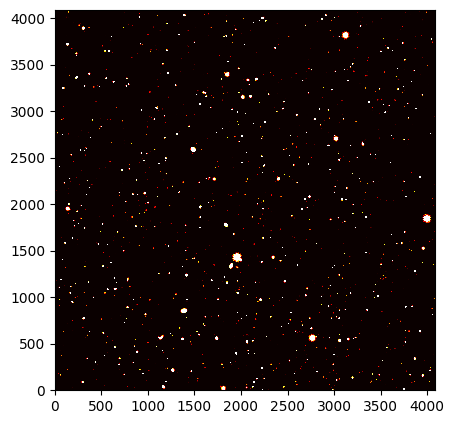

In [4]:
# Import convolution tools
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)
plt.imshow(convolved_data, vmin=0.3, vmax=1., cmap='hot', origin='lower')

#### 3) Simple Segmentation image

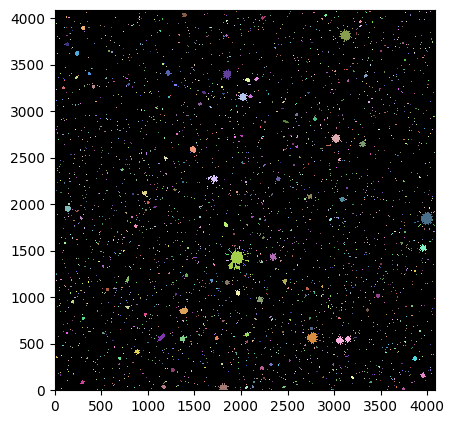

In [5]:
# Tools for segmentation
from photutils.segmentation import detect_sources

# threshold determines minimum pixel value considered for detection
threshold = 2 * bkg.background_rms # rms of the background we found earlier

# npixels determines minimum number of connected pixels required to define an object
# In this case, at least 10 8-connected pixels greater than the threshold value are required to define an object
segment_map = detect_sources(convolved_data, threshold, npixels=10)

# Plot our segmentation map
plt.imshow(segment_map, cmap=segment_map.cmap, origin='lower', interpolation='nearest')

#### 4) Deblending
If you examine the segmentation image we produced, you can identify several distinct object which are mistakenly labelled as one large object. Deblending tools retest the image at several threshold values to identify the valleys that serve as edges between objects.

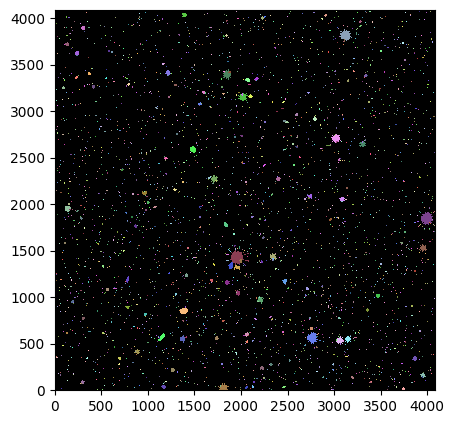

In [6]:
# Deblending Process
from photutils.segmentation import deblend_sources

# nlevels is the number of different threshold values to retest at 
# contrast is how different any two local peaks have to be to made separate; 0.001 = 7.5 magnitude difference
segm_deblend = deblend_sources(convolved_data, segment_map, npixels=10, nlevels=32, contrast=0.001, progress_bar=False)

# plot
plt.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap, interpolation='nearest')

Text(0.5, 1.0, 'Deblended Map')

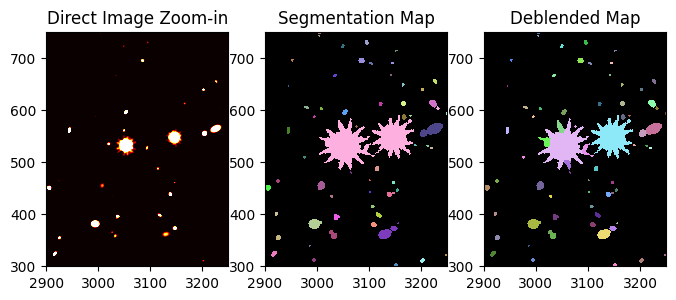

In [7]:
# Showing the need to deblend
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(convolved_data, vmin=0.4, vmax=1., cmap='hot', origin='lower')
ax1.set_xlim(2900, 3250)
ax1.set_ylim(300, 750)
ax1.set_title("Direct Image Zoom-in")

ax2.imshow(segment_map, cmap=segment_map.cmap, origin='lower', interpolation='nearest')
ax2.set_xlim(2900, 3250)
ax2.set_ylim(300, 750)
ax2.set_title("Segmentation Map")

ax3.imshow(segm_deblend, cmap=segm_deblend.cmap, origin='lower', interpolation='nearest')
ax3.set_xlim(2900, 3250)
ax3.set_ylim(300, 750)
ax3.set_title("Deblended Map")

#### 5) Simplified, all-in-one command
In practice, these steps can be combined using the SourceFinder class.

Text(0.5, 1.0, 'Separate Steps Map')

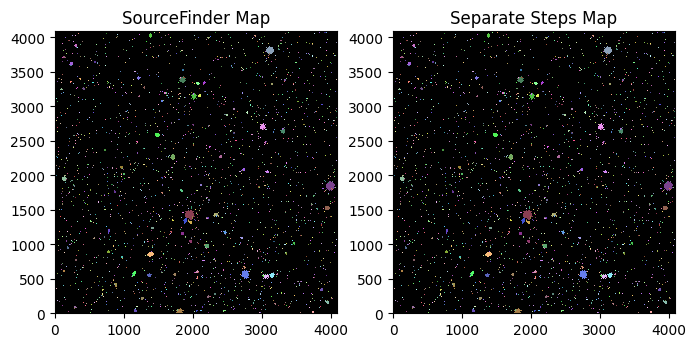

In [8]:
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, nlevels=32, contrast=0.001, progress_bar=False)

found_seg_map = finder(convolved_data, threshold)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(found_seg_map, cmap=found_seg_map.cmap, interpolation='nearest', origin='lower')
ax1.set_title("SourceFinder Map")

ax2.imshow(segm_deblend, cmap=segm_deblend.cmap, interpolation='nearest', origin='lower')
ax2.set_title("Separate Steps Map")

#### 6) Building a catalog
Building a catalog of these objects can be very useful for troubleshooting and examining images we produce. However, it is not neccessary for running a simulation.

In [9]:
# The SourceCatalog class gives photometry, centroid, and morphology information
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)

# to_table() creates an astropy QTable; pprint() is a QTable method that prints a formatted table
cat.to_table().pprint(max_width=-1)

label     xcentroid          ycentroid      sky_centroid bbox_xmin bbox_xmax bbox_ymin bbox_ymax  area   semimajor_sigma     semiminor_sigma       orientation         eccentricity          min_value            max_value      local_background    segment_flux    segment_fluxerr     kron_flux      kron_fluxerr
                                                                                                  pix2         pix                 pix                 deg                                                                                                                                                          
----- ------------------ ------------------ ------------ --------- --------- --------- --------- ------ ------------------ ------------------- ------------------- ------------------- --------------------- ------------------- ---------------- ------------------ --------------- ------------------ ------------
    1 453.00021469555776  3.227802839340533         None       449       